This file compiles all of the different datasets.

TODO:
- [ ] Add pairwise (gravity) file
- [ ] Figure out why there are different numbers of districts for each file

**Important note** Old PRMN data must be retrieved from Katherine's local desktop as it is not public.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy_utils import create_database, database_exists, drop_database

import jetson_configs as jcfg
from src.compile_data.compile_master import *
%matplotlib inline

In [2]:
data_dir = 'data/clean'

# Whether to use public or private prmn
use_public_prmn = jcfg.use_public_prmn

# Configure connection

In [3]:
#We supply our credentials and point to the database we're trying to connect to and
host     = jcfg.sql_host
user     = jcfg.sql_user
password = jcfg.sql_password
database = "jetson"

engine = create_engine(f'postgresql://{user}:{password}@{host}/{database}') 

In [4]:
# Load the SQL_magic extension and configure the connection
%reload_ext sql_magic
%config SQL.conn_name = 'engine'

# Compile admin1

In [5]:
acled        = pd.read_sql(f"SELECT * FROM acled_admin1",         con=engine, index_col=['region', 'date'])
prmn         = pd.read_sql(f"SELECT * FROM prmn_admin1",          con=engine, index_col=['region', 'date'])
fsnau        = pd.read_sql(f"SELECT * FROM fsnau_admin1",         con=engine, index_col=['region', 'date'])
ew_ea        = pd.read_sql(f"SELECT * FROM ew_ea_admin1",         con=engine, index_col=['region', 'date'])
distances    = pd.read_sql(f"SELECT * FROM distances_admin1",     con=engine, index_col=['region'])
ew_ea_rivers = pd.read_sql(f"SELECT * FROM monthly_ew_ea_rivers", con=engine, index_col=['date'])

In [6]:
master = pd.read_sql('SELECT * FROM master_admin1', con=engine, index_col=['region', 'date'])
master.sort_index(inplace=True)

In [7]:
# Check that there are only 18 regions
assert(len(master.index.get_level_values('region').unique())==18)

In [8]:
%%read_sql
SELECT max(date) FROM prmn_admin1

Query started at 12:59:02 AM Eastern Daylight Time; Query executed in 0.00 m

,max
0,2021-03-01


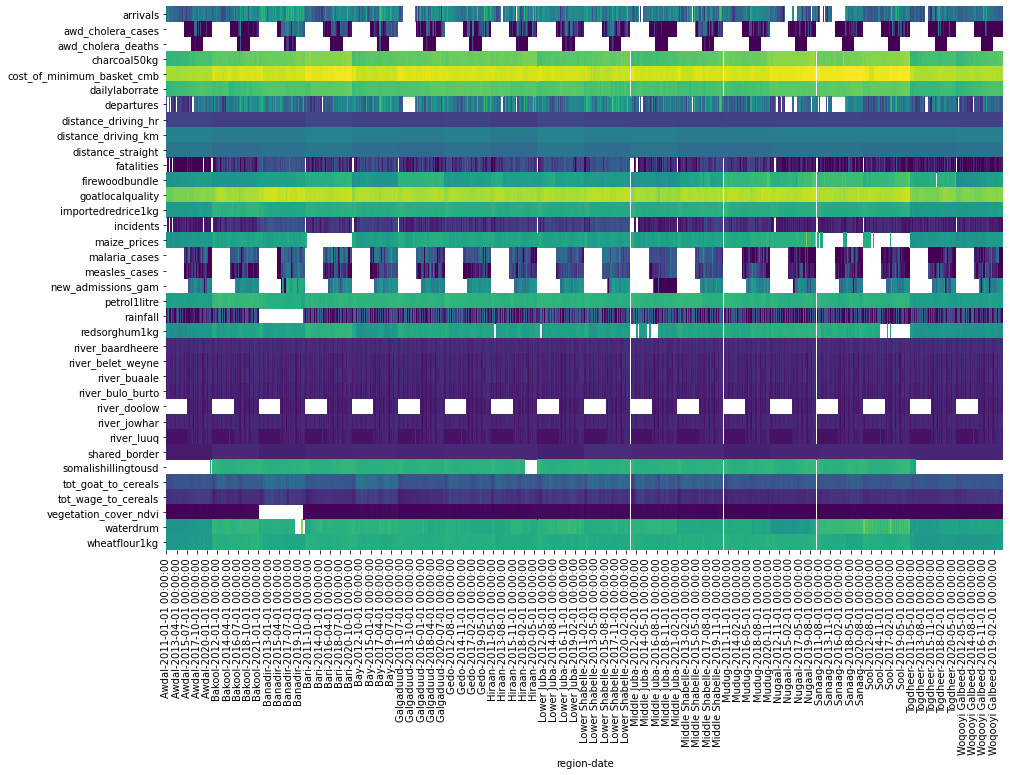

In [9]:
# Plot
fig, ax = plt.subplots(1,1, figsize=[15,10])
sns.heatmap(np.log(1+master.T).sort_index(level='date'), cbar=None, cmap='viridis', ax=ax)

## Create the public-facing Jetson dataset

In [10]:
# Convert admin names back to the Jetson standard
admin1_map = json.load(open('src/admin1_map.json'))
admin1_map = {v:k for k,v in admin1_map.items()}

master.reset_index(level='region', inplace=True)
master['region'] = master['region'].replace(admin1_map)
master.set_index('region', append=True, inplace=True)
master.sort_index(inplace=True)

In [11]:
river_cols = [ i for i in master.columns if 'river' in i ]

with pd.ExcelWriter('data/for_public/jetson_tables.xlsx') as writer:  
    master.loc['2016-01-01':].arrivals        .unstack(level='region').to_excel(writer, sheet_name='current_displacement')
    master.loc['2016-01-01':].departures      .unstack(level='region').to_excel(writer, sheet_name='before_displacement')
    master                   .incidents       .unstack(level='region').to_excel(writer, sheet_name='violent_incidents')
    master                   .fatalities      .unstack(level='region').to_excel(writer, sheet_name='fatalities')
    master                   .rainfall        .unstack(level='region').to_excel(writer, sheet_name='Rainfall_average')
    master                   .waterdrum       .unstack(level='region').to_excel(writer, sheet_name='Waterdrum_PriceSHS')
    master                   .goatlocalquality.unstack(level='region').to_excel(writer, sheet_name='LocalGoat_PriceSHS')
    #master[river_cols].reset_index(level='region',drop=True).drop_duplicates().to_excel(writer, sheet_name='River_Levels')
    # 'CashAssistance_individuals'

# Compile Admin2

In [12]:
acled        = pd.read_sql(f"SELECT * FROM acled_admin2",         con=engine, index_col=['region', 'district', 'date'])
prmn         = pd.read_sql(f"SELECT * FROM prmn_admin2",          con=engine, index_col=['region', 'district', 'date'])
fsnau        = pd.read_sql(f"SELECT * FROM fsnau_admin2",         con=engine, index_col=['region', 'district', 'date'])
ew_ea        = pd.read_sql(f"SELECT * FROM ew_ea_admin2",         con=engine, index_col=['region', 'district', 'date'])
distances    = pd.read_sql(f"SELECT * FROM distances_admin2",     con=engine, index_col=['district'])
ew_ea_rivers = pd.read_sql(f"SELECT * FROM monthly_ew_ea_rivers", con=engine, index_col=['date'])

In [13]:
master = pd.read_sql('SELECT * FROM master_admin2', con=engine, index_col=['region', 'district', 'date'])
master.sort_index(inplace=True)

In [14]:
len(distances.index)

74

In [15]:
len(prmn.index.get_level_values('district').unique())

94

In [16]:
len(acled.index.get_level_values('district').unique())

93

In [17]:
len(ew_ea.index.get_level_values('district').unique())

74

In [18]:
len(fsnau.index.get_level_values('district').unique())

61

In [19]:
# Confirm the right number of regions
assert(len(master.index.get_level_values("region").unique())==18)

# Check the number of districts
len(master.index.get_level_values("district").unique())

107

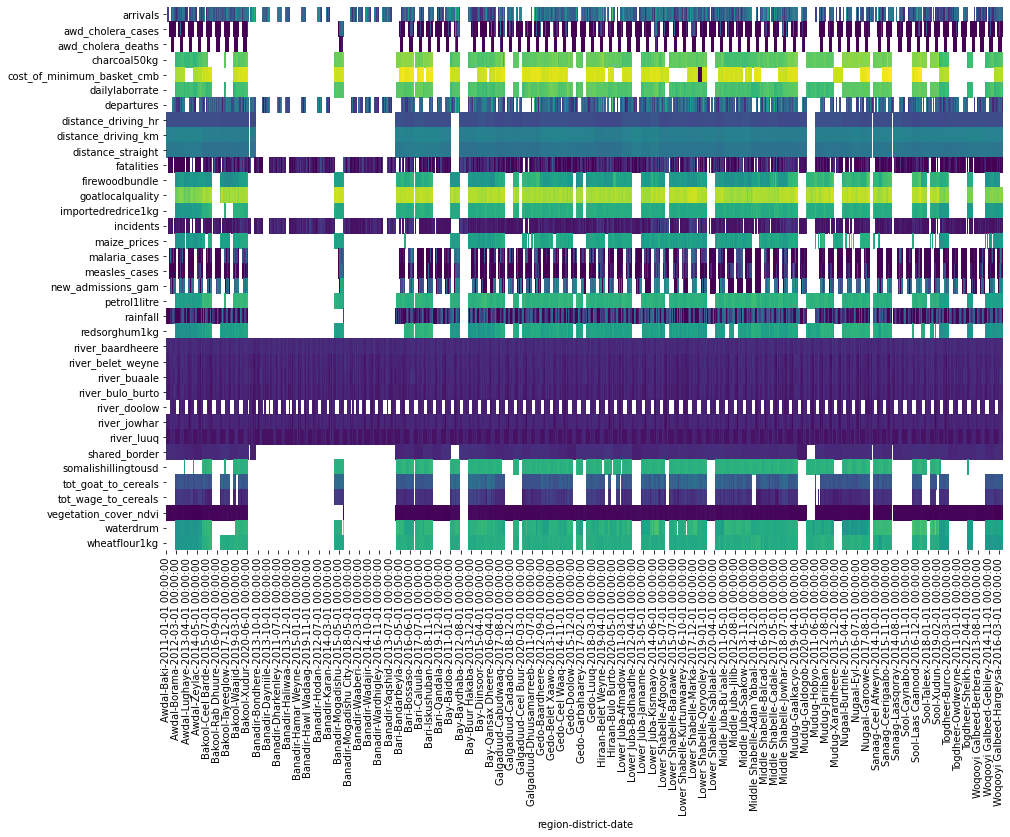

In [20]:
# Plot
fig, ax = plt.subplots(1,1, figsize=[15,10])
sns.heatmap(np.log(1+master.T).sort_index(level='district'), cbar=None, cmap='viridis', ax=ax)

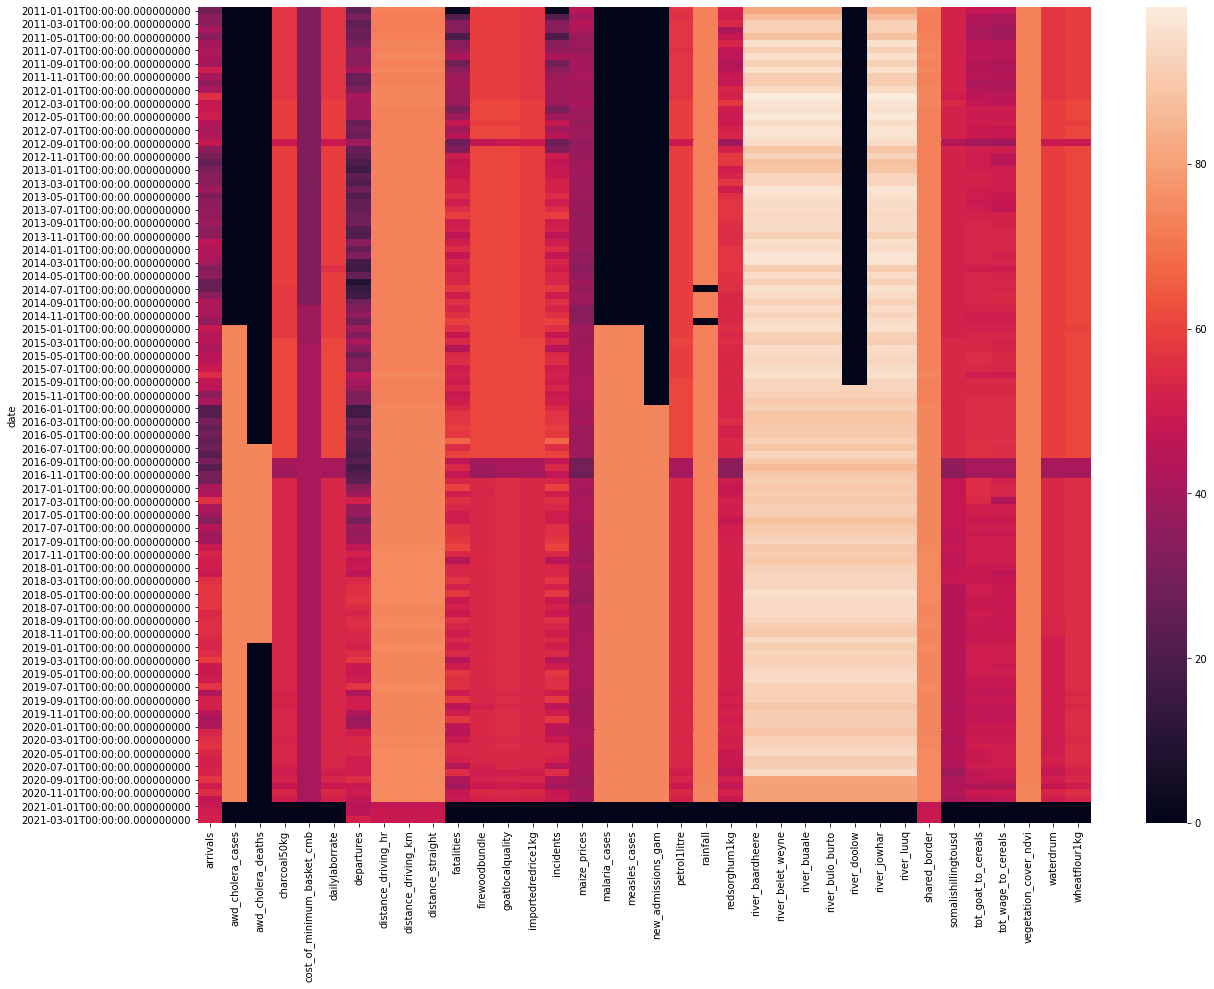

In [21]:
fig, ax = plt.subplots(1,1,figsize=[20,15])
sns.heatmap(master.groupby(level='date').count(), ax=ax)